# MNIST train

This is a part of some experiments for Knowledge Distillation.

- Train an MNIST model
- Train a smaller model (trainee) using Knowledge distillation
    - Find optimal parameter configs
- Compare with other training strategies
    - Train the smaller model from scratch
    - Train the smaller model from the trainee model's weights - does it diverge?
- Relevant metrics
    - Precision, recall, accuracy
    - Time the models

Other experiments to try:
- Other datasets?
- Mixture of experts -> one model somehow? (there'll be multiple soft targets OR mean them..)
- KD wrt different architectures:
    - ResNet -> ResNet?
    - ResNet -> simpler architecture
    - Simpler architecture to ResNet

### Other unrelated ideas

- Training strategies
    - Training techniques and tricks
        - Hard negative mining and how it helps
    - Curriculum learning
    - Annealing learning rates
    - Cyclic learning rates
    - Batch normalization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
from torch import autograd, nn, optim
import torch.nn.functional as F

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data

In [4]:
df_train_val = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [5]:
df_train_val.shape, df_test.shape

((42000, 785), (28000, 784))

(array([4132., 4684., 4177., 4351., 4072., 3795., 4137., 4401., 4063.,
        4188.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

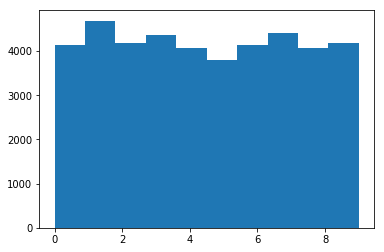

In [6]:
plt.hist(df_train_val.label)

### Split train into train-val

In [42]:
from src import data, train

In [17]:
df_train, df_val = data.split_train_val(df_train_val)

In [19]:
df_train.shape, df_val.shape

((37800, 785), (4200, 785))

### Create dataloaders

In [25]:
%%time
dataset_train = data.get_dataset(df_train)
dataset_val = data.get_dataset(df_val)

CPU times: user 919 ms, sys: 1.65 s, total: 2.57 s
Wall time: 2.58 s


In [26]:
print(len(dataset_train))
print(len(dataset_val))

37800
4200


In [27]:
batch_size = 8

In [32]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

#### Test dataset

In [37]:
dataset_test = data.get_dataset(df_test)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

/home/anuj/code/Experiments/Vision/Detection/chardet/mnist_kd/src/data.py:25: UserWarning: This dataframe does not have labels! Using default label = -100
  df = df.copy()


### Visualize a few images

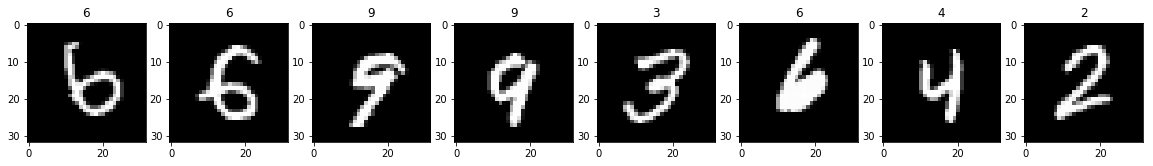

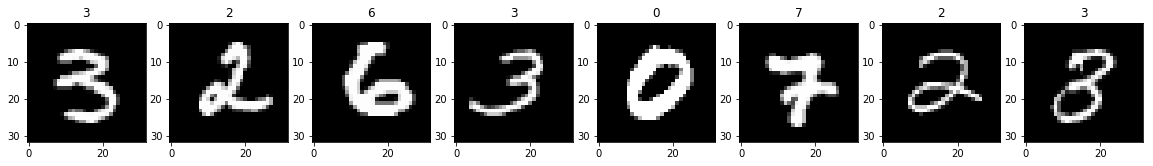

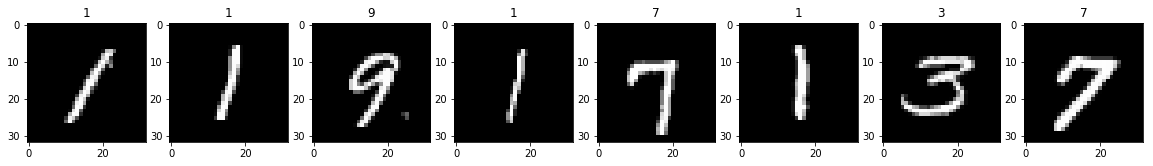

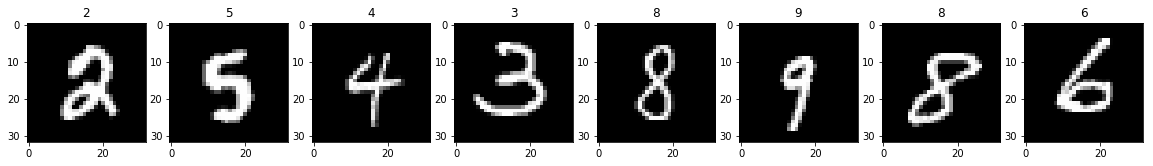

In [49]:
data.visualize_data(dataloader_train)

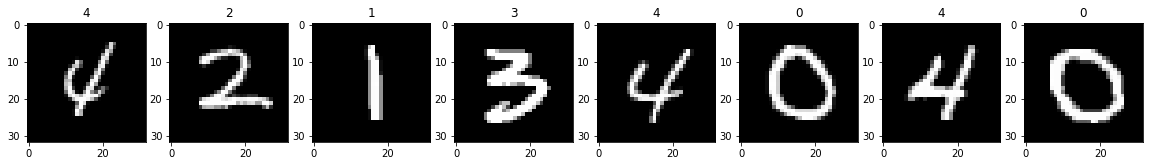

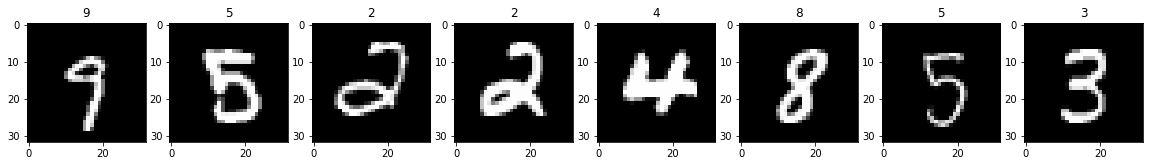

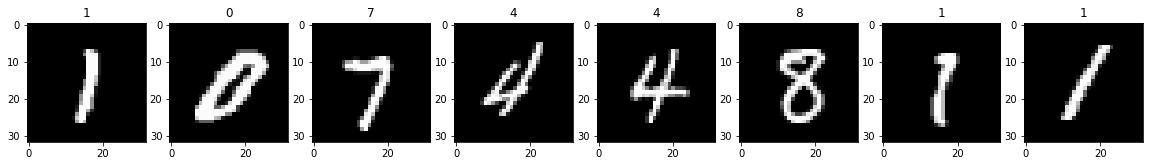

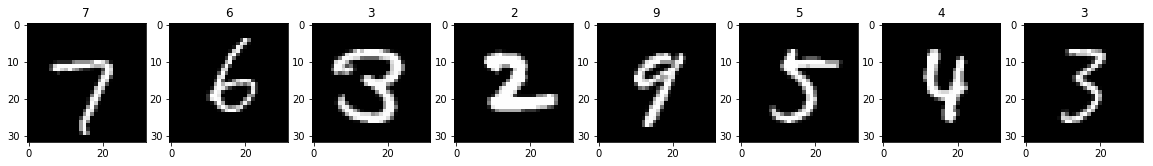

In [48]:
data.visualize_data(dataloader_val)

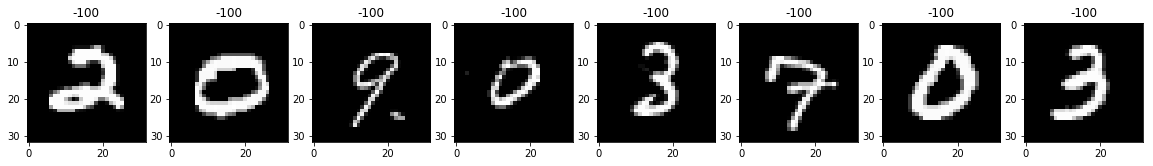

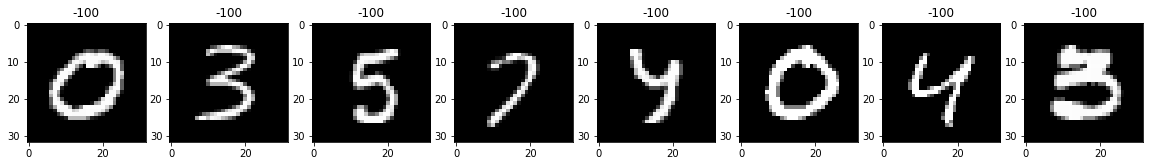

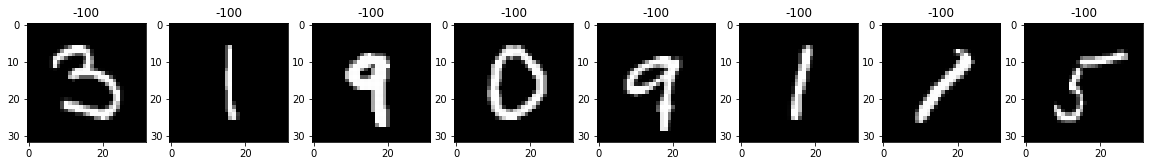

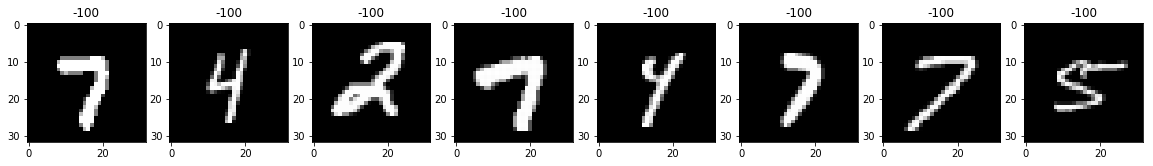

In [50]:
data.visualize_data(dataloader_test)

### Get the relative label weights

In [60]:
loss_weights = np.bincount(df_train_val['label'])

In [61]:
loss_weights = 1. / loss_weights
loss_weights = loss_weights / loss_weights.sum()

Text(0,0.5,'Loss weight')

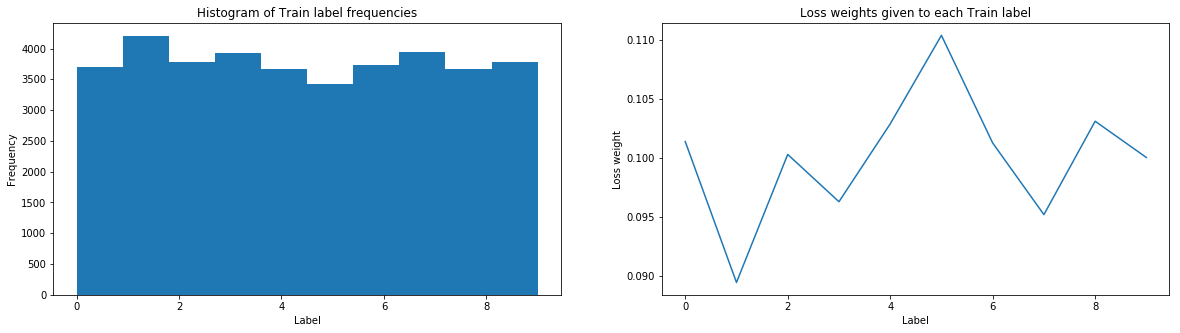

In [62]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(df_train['label'])
plt.title('Histogram of Train label frequencies')
plt.xlabel('Label')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.plot(loss_weights)
plt.title('Loss weights given to each Train label')
plt.xlabel('Label')
plt.ylabel('Loss weight')

In [63]:
del df_train, df_val, df_train_val

## Model

### Create a simple model

### Train

In [58]:
from src import models

In [59]:
model, params = models.get_model_and_params(models.Net, gpu=0)

628,682 trainable paramaters!


In [64]:
loss_weights = torch.FloatTensor(loss_weights)

loss = nn.NLLLoss(weight=loss_weights).cuda()
optimizer = optim.SGD(params, lr=1e-3)

In [ ]:
# Weights and logging directories
model_str = 'MNIST-big-1.09'

path_to_weights = pathlib.Path('/opt/anuj/weights') / model_str
path_to_log_s = '../tensorboard_logs/{}'.format(model_str)

# To prevent over-writing!
os.makedirs(str(path_to_weights), exist_ok=True)
writer = tensorboardX.SummaryWriter(path_to_log_s)

In [ ]:
train(model)

## Test

In [ ]:
model.load_state_dict(torch.load('/opt/anuj/weights/MNIST-big-1.09/18.pt'))

In [ ]:
validate_model(model, dataloader_val, loss, n_iters=500)

In [ ]:
%%time
test_labels = predict(model, dataloader_test, first_n=-1)

In [ ]:
len(test_labels)

In [ ]:
df_test['pred_labels'] = test_labels

In [ ]:
test_labels[:10]

In [ ]:
df_test['ImageId'] = df_test.index + 1

In [ ]:
df_test[['ImageId', 'pred_labels']].rename({'pred_labels': 'Label'}, axis=1)\
                                   .to_csv('test_pred.csvd.csv', index=False)